In [1]:
import torch
from torchvision import transforms, models
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
import random
from vcs2425 import ApplyColormap, train, evaluate, evaluate_topk, plot_training_curves, load_dataset_splits
import time

# 1. Reproducibility
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)

# 2. Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
COLOR_MAP = 'stacked'

# 3. Transforms
train_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.RandomCrop((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    ApplyColormap(cmap=COLOR_MAP),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop((224, 224)),
    ApplyColormap(cmap=COLOR_MAP),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [ ]:
# 4. Load full dataset
train_dataset, val_dataset = load_dataset_splits('../../ILSVRC2012_depth', train_transform, val_transform)

BATCH_SIZE = 32

# 7. DataLoaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=8,
    pin_memory=True,  # Better memory management
    persistent_workers=True  # Keep workers alive between iterations
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE, 
    shuffle=False,
    num_workers=8,
    pin_memory=True,  # Better memory management
    persistent_workers=True  # Keep workers alive between iterations
)

# Training


We are going to train only the classifier

In [4]:
model = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1)

for param in model.parameters():
    param.requires_grad = True

model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [5]:
# Print the number of trainable and frozen parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
frozen_params = total_params - trainable_params

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Frozen parameters: {frozen_params:,}")

Total parameters: 143,667,240
Trainable parameters: 143,667,240
Frozen parameters: 0


# Fine Tuning Classifier


In [6]:
LEARNING_RATE = 5e-5
WEIGHT_DECAY = 1e-4
REDUCE_LR_PATIENCE = 3
REDUCE_LR_FACTOR = 0.5

# 9. Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=REDUCE_LR_FACTOR, patience=REDUCE_LR_PATIENCE)

In [7]:
NUM_EPOCHS = 30
MODEL_NAME = 'vgg19_ft'

train_losses = []
train_accuracies = []
eval_losses = []
eval_accuracies = []


for epoch in range(NUM_EPOCHS):
    start_time = time.time()

    train_loss, train_accuracy = train(model, 
        loader=train_loader, 
        criterion=criterion, 
        optimizer=optimizer,
        device=device,
        model_name=MODEL_NAME)

    train_time = time.time()

    eval_loss, eval_accuracy = evaluate(model, 
                                        loader=val_loader, 
                                        device=device,
                                        criterion=criterion)
    
    scheduler.step(eval_loss)
    
    eval_time = time.time()
    
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} Time: {(eval_time-start_time):.2f}s - \n"
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Took {(train_time-start_time):.2f}s, \n"
          f"Val Loss: {eval_loss:.4f}, Val Accuracy: {eval_accuracy:.4f}, Took {(eval_time-train_time):.2f}s \n")

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    eval_losses.append(eval_loss)
    eval_accuracies.append(eval_accuracy)

print("Training Complete!")

Epoch 1/30 Time: 412.63s - 
Train Loss: 3.9580, Train Accuracy: 0.2008, Took 385.03s, 
Val Loss: 3.3516, Val Accuracy: 0.2807, Took 27.60s 



Epoch 2/30 Time: 391.64s - 
Train Loss: 3.1655, Train Accuracy: 0.3016, Took 366.01s, 
Val Loss: 3.1407, Val Accuracy: 0.3056, Took 25.63s 



Epoch 3/30 Time: 382.73s - 
Train Loss: 2.7413, Train Accuracy: 0.3698, Took 354.99s, 
Val Loss: 3.0085, Val Accuracy: 0.3350, Took 27.74s 



Epoch 4/30 Time: 402.05s - 
Train Loss: 2.4141, Train Accuracy: 0.4253, Took 374.07s, 
Val Loss: 3.0121, Val Accuracy: 0.3387, Took 27.98s 



Epoch 5/30 Time: 375.08s - 
Train Loss: 2.1368, Train Accuracy: 0.4794, Took 349.41s, 
Val Loss: 3.1101, Val Accuracy: 0.3379, Took 25.67s 



Epoch 6/30 Time: 370.91s - 
Train Loss: 1.5558, Train Accuracy: 0.5955, Took 345.26s, 
Val Loss: 3.0836, Val Accuracy: 0.3648, Took 25.65s 



Epoch 7/30 Time: 371.73s - 
Train Loss: 1.3287, Train Accuracy: 0.6498, Took 346.08s, 
Val Loss: 3.2012, Val Accuracy: 0.3649, Took 25.65s 



Epoch 8/30 Time: 375.05s - 
Train Loss: 1.1664, Train Accuracy: 0.6864, Took 349.39s, 
Val Loss: 3.3269, Val Accuracy: 0.3498, Took 25.66s 



Epoch 9/30 Time: 373.40s - 
Train Loss: 1.0338, Train Accuracy: 0.7166, Took 347.73s, 
Val Loss: 3.4154, Val Accuracy: 0.3603, Took 25.67s 



Epoch 10/30 Time: 372.79s - 
Train Loss: 0.9145, Train Accuracy: 0.7471, Took 347.16s, 
Val Loss: 3.5306, Val Accuracy: 0.3532, Took 25.63s 



Epoch 11/30 Time: 371.82s - 
Train Loss: 0.8099, Train Accuracy: 0.7728, Took 346.15s, 
Val Loss: 3.5856, Val Accuracy: 0.3568, Took 25.66s 



Epoch 12/30 Time: 372.46s - 
Train Loss: 0.7336, Train Accuracy: 0.7911, Took 346.82s, 
Val Loss: 3.7941, Val Accuracy: 0.3592, Took 25.64s 



Epoch 13/30 Time: 374.37s - 
Train Loss: 0.6576, Train Accuracy: 0.8118, Took 348.74s, 
Val Loss: 3.9453, Val Accuracy: 0.3581, Took 25.63s 



Epoch 14/30 Time: 370.41s - 
Train Loss: 0.6033, Train Accuracy: 0.8262, Took 344.81s, 
Val Loss: 4.0055, Val Accuracy: 0.3571, Took 25.60s 



Epoch 15/30 Time: 370.33s - 
Train Loss: 0.5507, Train Accuracy: 0.8403, Took 344.73s, 
Val Loss: 4.1562, Val Accuracy: 0.3589, Took 25.60s 



Epoch 16/30 Time: 369.23s - 
Train Loss: 0.5113, Train Accuracy: 0.8504, Took 343.61s, 
Val Loss: 4.0262, Val Accuracy: 0.3605, Took 25.62s 



Epoch 17/30 Time: 387.80s - 
Train Loss: 0.4711, Train Accuracy: 0.8609, Took 360.02s, 
Val Loss: 4.1957, Val Accuracy: 0.3591, Took 27.77s 



Epoch 18/30 Time: 396.80s - 
Train Loss: 0.4474, Train Accuracy: 0.8688, Took 371.17s, 
Val Loss: 4.1949, Val Accuracy: 0.3501, Took 25.63s 



Epoch 19/30 Time: 373.38s - 
Train Loss: 0.4218, Train Accuracy: 0.8743, Took 347.76s, 
Val Loss: 4.2667, Val Accuracy: 0.3523, Took 25.62s 



Epoch 20/30 Time: 374.37s - 
Train Loss: 0.3953, Train Accuracy: 0.8830, Took 348.74s, 
Val Loss: 4.3686, Val Accuracy: 0.3489, Took 25.63s 



Epoch 21/30 Time: 375.96s - 
Train Loss: 0.3758, Train Accuracy: 0.8876, Took 350.34s, 
Val Loss: 4.4604, Val Accuracy: 0.3387, Took 25.63s 



Epoch 22/30 Time: 375.08s - 
Train Loss: 0.3542, Train Accuracy: 0.8946, Took 349.43s, 
Val Loss: 4.4457, Val Accuracy: 0.3495, Took 25.65s 



Epoch 23/30 Time: 370.77s - 
Train Loss: 0.3414, Train Accuracy: 0.8969, Took 345.13s, 
Val Loss: 4.6021, Val Accuracy: 0.3490, Took 25.64s 



Epoch 24/30 Time: 372.53s - 
Train Loss: 0.3167, Train Accuracy: 0.9050, Took 346.89s, 
Val Loss: 4.6334, Val Accuracy: 0.3517, Took 25.64s 



Epoch 25/30 Time: 371.69s - 
Train Loss: 0.3074, Train Accuracy: 0.9074, Took 346.05s, 
Val Loss: 4.5438, Val Accuracy: 0.3483, Took 25.64s 



Epoch 26/30 Time: 369.12s - 
Train Loss: 0.2966, Train Accuracy: 0.9107, Took 343.50s, 
Val Loss: 4.1714, Val Accuracy: 0.3460, Took 25.63s 



Epoch 27/30 Time: 372.47s - 
Train Loss: 0.2875, Train Accuracy: 0.9141, Took 346.83s, 
Val Loss: 4.9414, Val Accuracy: 0.3464, Took 25.64s 



Epoch 28/30 Time: 372.55s - 
Train Loss: 0.2775, Train Accuracy: 0.9176, Took 346.89s, 
Val Loss: 4.8013, Val Accuracy: 0.3493, Took 25.66s 



Epoch 29/30 Time: 372.54s - 
Train Loss: 0.2739, Train Accuracy: 0.9188, Took 346.91s, 
Val Loss: 4.7352, Val Accuracy: 0.3399, Took 25.63s 



Epoch 30/30 Time: 385.50s - 
Train Loss: 0.2557, Train Accuracy: 0.9228, Took 357.61s, 
Val Loss: 4.7373, Val Accuracy: 0.3438, Took 27.89s 

Training Complete!


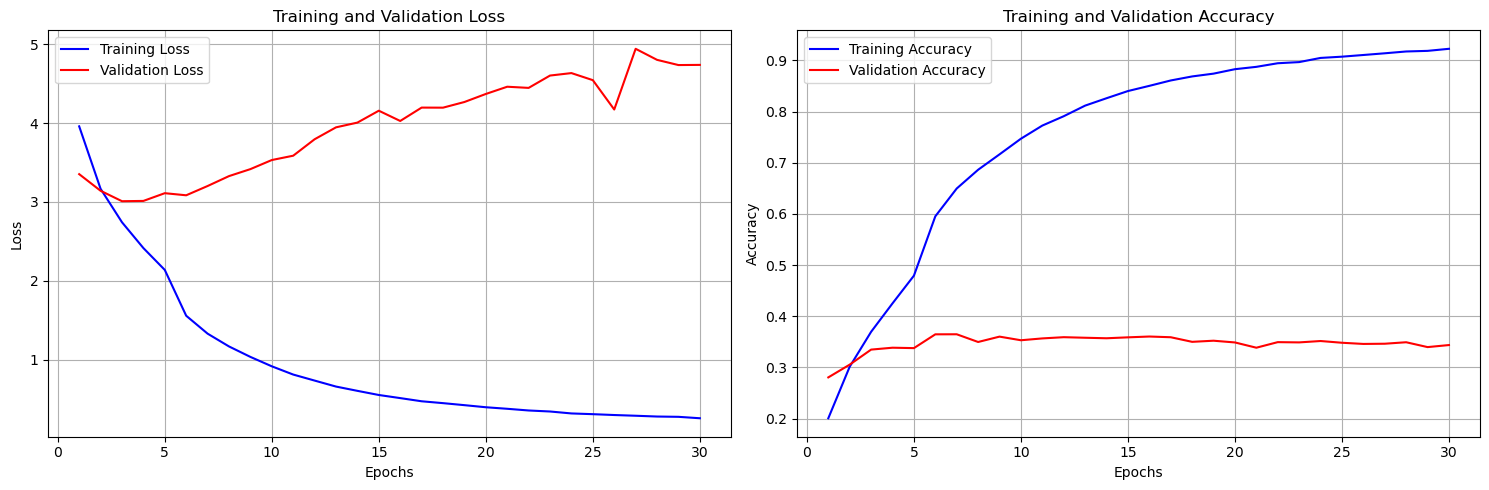

In [8]:
plot_training_curves(
    (train_losses, train_accuracies),
    (eval_losses, eval_accuracies),
)

# Evaluation metrics

In [9]:
# Load the best model weights
best_model_path = f"{MODEL_NAME}.pth"

# Load the saved model weights
model.load_state_dict(torch.load(best_model_path))
model.eval()  # Set the model to evaluation mode
print(f"Loaded best model from {best_model_path}")

# Evaluate the loaded model
val_loss, val_accuracy = evaluate(model, val_loader, criterion, device=device)
print(f"Best model - Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

Loaded best model from vgg19_ft.pth


Best model - Validation Loss: 4.6049, Validation Accuracy: 0.3419


In [10]:
top_1 = evaluate_topk(model, val_loader, k=1, device=device)
top_5 = evaluate_topk(model, val_loader, k=5, device=device)

print(f"Colormap: {COLOR_MAP}, Top-1 Accuracy: {top_1:.4f}, Top-5 Accuracy: {top_5:.4f}")

Colormap: stacked, Top-1 Accuracy: 0.3420, Top-5 Accuracy: 0.6096
